# Root Finding in 1 Dimension
## Christina Lee
## Numerics

When does a value reach zero?

When will I have spent all my money?
When will Siberian tigers go extinct? Will they?
At what altitude do I need to place a satellite to ensure it remains stationary with respect to the surface of the Earth? 
Where will this cannonball hit the ground?

Solving these types of problems involves the application of <i>Root Finding</i>, or determining when a value crosses zero.

____


Paradoxically, you should always generally know what your answer is before you use before a Root Finding Algorithm.

I'll explain what I mean.

These methods are suitable for refining the precise value of a zero once you already have a general idea of the behavior of the function.  Otherwise, you might fall into one of the algorithm's pitfalls and remain blissfully ignorant of how completely wrong you are.  These methods are <b>NOT</b> golden hammers you can go around swinging at things willy-nilly and expecting wonderful answers to just appear.

Number one solution to avoid root-finding catastrophe?
<b>GRAPH THE FUNCTION</b>

Number two?  Also, <b>GRAPH THE FUNCTION</b>.

Mostly, figure out as much behavior beforehand as you can.  
* What are its limits?  
* Does it diverge anywhere? 
* Is it smooth and well behaved? 
* Do we have a derivative? 
* Could we have an even multiplicity situation?

In [1]:
using ForwardDiff
using Statistics
using SpecialFunctions
using Plots
gr()

┌ Info: Recompiling stale cache file /home/shaula/.julia/compiled/v1.0/ForwardDiff/k0ETY.ji for ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
└ @ Base loading.jl:1187
┌ Info: Recompiling stale cache file /home/shaula/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1187


Plots.GRBackend()

### Multiplicity

The function $x^2-1$ intersects the x-axis twice. 

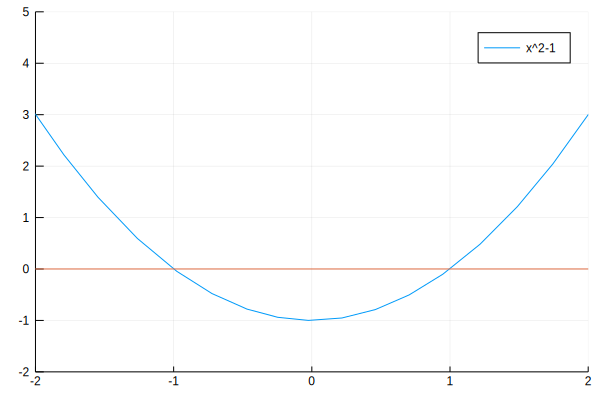

In [15]:
plot(x->x^2-1,label="x^2-1")
hline!([0],label="")
plot!(xlims=(-2,2),ylims=(-2,5))

 As we move the graph up, at the function $x^2$ only intersects once, but we consider it a <i>zero of multiplicity two</i>. We count the zero of $x^2$ as an ''axis-crossing going down'' and an ''axis-crossing going up'' both at the same time.  

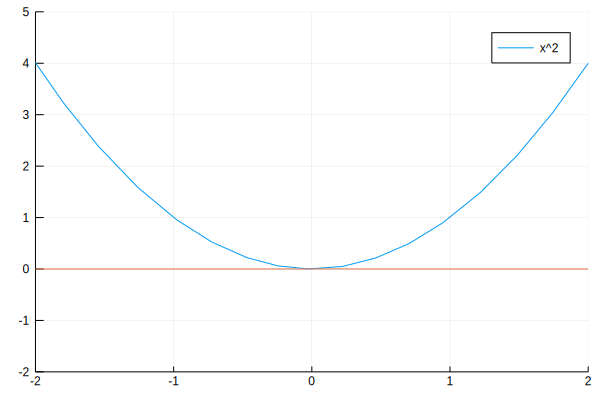

In [23]:
plot(x->x^2,label="x^2")
hline!([0],label="")
plot!(xlims=(-2,2),ylims=(-2,5))

If we have multiplicity three like $x^3$ at zero, the function goes up, then down, then back up again.  Overall, $x^3$ heads straight across the x-axis.  We see these three zeros seperately if we perturb the function with another term, like $-2x$.

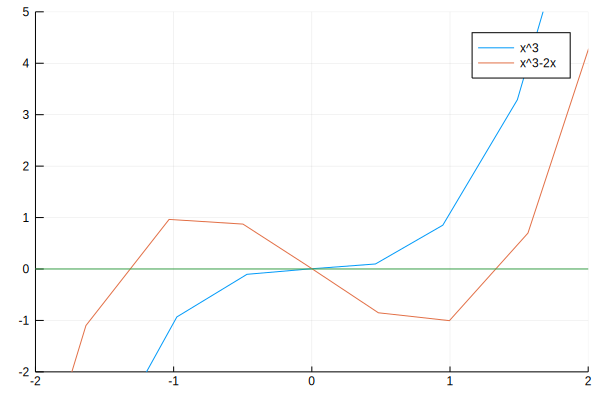

In [24]:
plot(x->x^3,label="x^3")
plot!(x->x^3-2x,label="x^3-2x")
hline!([0],label="")
plot!(xlims=(-2,2),ylims=(-2,5))

Again at another even multiplicity, $x^4$ with multiplicity 4, the function goes down, up, down, then up.  Overall, $x^4$ hits the axis but never crosses it.  

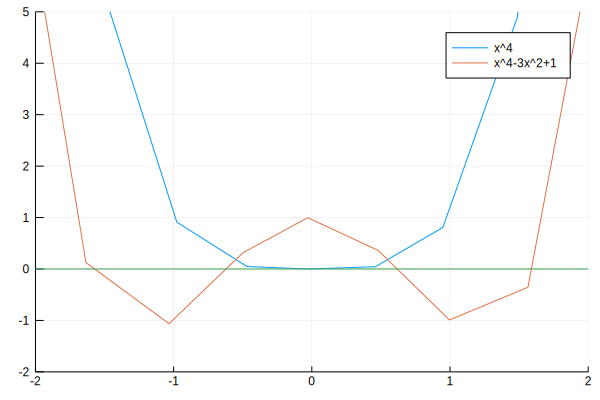

In [44]:
plot(x->x^4,label="x^4")
plot!(x->x^4-3x^2+1,label="x^4-3x^2+1")
hline!([0],label="")
plot!(xlims=(-2,2),ylims=(-2,5))

When we have zeros of even multiplicity, we will <b>hit the axis</b> $f(x)=0$, but <b>never change signs</b>.  

This lack of changing signs is the significant bit, as it makes confirming the existence of a zero somewhat tricky and eliminates certain methods from our arsenal.

## Methods

In this post, we cover:

* Midpoint
* Newton-Raphson
* Secant
* Regula-Falsi

## Test Functions

* $f(x)= 2 \cos(x) - x + x^2/10$
* $x^2$
* $1/x$
* $\text{loop}(x)=x^3 - 2x +2 $
* $x^{1/3}$
* $\cos(2\pi x) - 0.4 x$

The first function is a standard run-of-the-mill transcendental function.  Transcendental: a function that involves non-polynomial terms.  The non-polynomial terms will usually prevent the determination of zeros by algebraic means.

The other functions will pose interesting challenges for one or more of the methods.

In [45]:
f(x) = 2*cos(x)-x+x^2/10
x2(x)=x^2
recip(x)=1/x
loop(x)=x^3-2x+2
cubert(x)=cbrt(x)
n_roots(x)=cos(2*pi*x)-0.4*x

n_roots (generic function with 1 method)

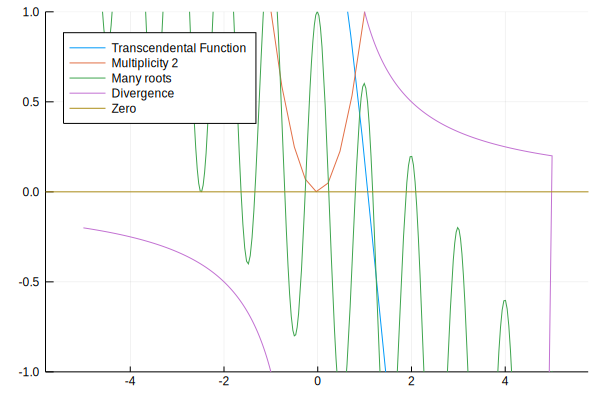

In [46]:
xh=collect(0.01:0.01:5)

plot(f,label="Transcendental Function"
    ,ylims=(-1,1),legend=:topleft)
plot!(x2,label="Multiplicity 2")
plot!(n_roots,label="Many roots")
plot!(vcat(xh,-xh),vcat(recip.(xh),recip.(-xh)),label="Divergence")
hline!([0],label="Zero")

## Interchangeability 

The first time I implement an algorithm, I usually don't wrap it up into a function at all. Once I do wrap it into a function, the function, I take just the inputs required for what I wrapped up in some random order and send back some large chunk of data.   There is nothing wrong with just slapping things together till they work, but like in this post here when I have functions that achieve the same thing, a little editing can make things better.  

Some of the methods here require brackets, some points, some derivative functions, or just some other combination of all these.  With this variability, how do we standardize the inputs? Fiddling till I find something that works.  I wrapped inputs up into values that get interated and values that don't.

When all the inputs and outputs are standardized for our methods, I can then plug them into another apparatus like this next function, the 'Zero_Iterator'.

In [51]:
function Zero_Iterator(f::Function,Method::Function,
        iterated_values0::Array{Float64},params,N)
    
    n_values=zeros(Float64,length(iterated_values0),N)
    n_values[:,1]=iterated_values0;
    
    for ii in 2:N
        n_values[:,ii] = Method(f,n_values[:,(ii-1)],params)
    end
    return n_values
end

Zero_Iterator (generic function with 1 method)

## Midpoint Method

In the midpoint method, we try localizing the root into successively smaller and smaller intervals by breaking the bracket in half each time.  We determine which half the zero is located in by determining <i>where the function changes sign</i>.  
    
As long as the function changes sign and we have bracketed a legitimate zero, we are good to go. This method will steadily and surely hone in on a zero for us.

BUT, if the function doesn't change sign ($x^2$) or if we haven't bracketed a legitimate zero ($1/x$ divergence) the method will steadily and surely lead us to absolutely nothing.

In [52]:
function Midpoint(f::Function,endpoints::Array{Float64},params)
    if f(endpoints[1])*f(endpoints[2])>0
        println("Endpoints must bracket a zero.  Please pick better endpoints.")
        error()
    end
    c=mean(endpoints)
    if f(endpoints[1])*f(c)<0
        return [ endpoints[1],c]
    elseif f(c)*f(endpoints[2])<0
        return [c, endpoints[2]]
    elseif f(c) ==0 
        print("midpoint is zero")
        return [c,c]
    else   
        println("Mid point doesn't bracket a zero... somethign weird...")
        print(c,"\t",f(c))
    end
end

Midpoint (generic function with 1 method)

In [7]:
endpoints_M_f=Zero_Iterator(f,Midpoint,[-1.0,2.0],["null"],10)
dx_M_f=endpoints_M_f[2,:]-endpoints_M_f[1,:]

10-element Array{Float64,1}:
 3.0        
 1.5        
 0.75       
 0.375      
 0.1875     
 0.09375    
 0.046875   
 0.0234375  
 0.01171875 
 0.005859375

In [8]:
endpoints_M_recip=Zero_Iterator(recip,Midpoint,[-1.4,1.0],["null"],10)
dx_M_recip=endpoints_M_recip[2,:]-endpoints_M_recip[1,:]

10-element Array{Float64,1}:
 2.4      
 1.2      
 0.6      
 0.3      
 0.15     
 0.075    
 0.0375   
 0.01875  
 0.009375 
 0.0046875

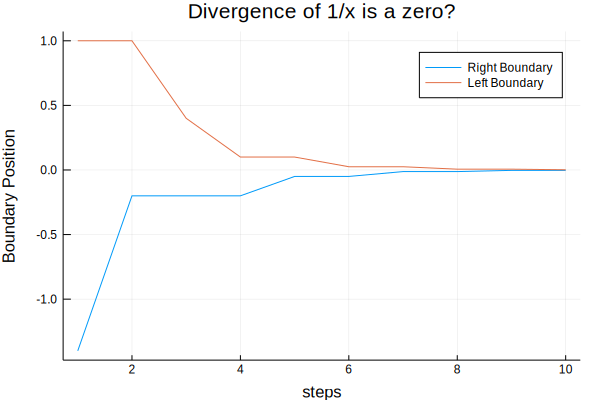

In [9]:
plot(transpose(endpoints_M_recip),label=["Right Boundary","Left Boundary"])
plot!(title="Divergence of 1/x is a zero?"
    ,xlabel="steps",ylabel="Boundary Position")

In [54]:
endpoints_M_zeta=Zero_Iterator(zeta,Midpoint,[-17.1,-15.],["null"],10)
dx_M_zeta=endpoints_M_zeta[2,:]-endpoints_M_zeta[1,:]

10-element Array{Float64,1}:
 2.1000000000000014   
 1.0500000000000007   
 0.5250000000000004   
 0.2624999999999993   
 0.13124999999999964  
 0.06562500000000071  
 0.03281249999999858  
 0.01640624999999929  
 0.008203124999999645 
 0.0041015625000007105

In [60]:
recip

recip (generic function with 1 method)

In [62]:
Zero_Iterator(n_roots,Midpoint,[-5.,5.],["null"],10)

2×10 Array{Float64,2}:
 -5.0  0.0  0.0  0.0   0.0    0.0     0.15625  0.234375  0.234375  0.234375
  5.0  5.0  2.5  1.25  0.625  0.3125  0.3125   0.3125    0.273438  0.253906

## Newton-Raphson Method

The Newton-Raphson Method uses the derivative at a point to extrapolate to where a zero would occur if the function was sufficiently well approximated by the derivative.  Even curvature and higher expansion terms do largely influence the function, we at least get going in the right direction, so the next iteration will be better.  We'll see that with $x^2$ near $0$.

When the function is well approximated by its derivative, this method works extremely well.  

Con: We need a derivative. What if we want to find the zero of experimental data? Or something really convoluted like the Riemann Zeta function? 

How does it work?  Let's take a look at this picture (that we will calculate later)
![](../images/Roots/nrmethod.png)
We follow the derivative to zero, then use that intercept as our next approximation.  Taking the new slope, we again follow the line to zero.  We get a new intercept and repeat the process.

In [13]:
function Newtons(f::Function,x::Array,fp::Array)
    return [ x[1]- f(x[1])/fp[1](x[1]) ]
end

Newtons (generic function with 1 method)

We can analytically calculating derivatives using 'ForwardDiff.jl'.  The syntax is

    f_prep(x::Vector)=f(x[1])
    f_prep2=(x->ForwardDiff.gradient(f_prep,x))
    fp(x)=f_prep2(x .*[1.])[1]

For the relevant functions, I'm just going to type out the derivatives, but if you don't want to take the derivatives yourself, you can use those lines of code.

In [47]:
fp(x)=-2*sin(x)-1+1/5*x
dx2(x)=2*x
drecip(x)=-1/x^2
dloop(x)=3x^2-2
dcubert(x)=(1.0/3.0)*cbrt(x^(-2))

dcubert (generic function with 1 method)

In [19]:
x_NR_f=Zero_Iterator(f,Newtons,[2.0],[fp],10)[1,:]
dx_NR_f=x_NR_f.-x_NR_f[end]

println("ii \t Guess \t\t\t dx")
for ii in 1:length(x_NR_f)
    println(ii,"\t",x_NR_f[ii],"\t",dx_NR_f[ii])
end

ii 	 Guess 			 dx
1	2.0	0.9281352793610165
2	0.9943360420939289	-0.07752867854505463
3	1.0728910967625935	0.0010263761236100066
4	1.0718648772052064	1.5656622287529842e-7
5	1.0718647206389873	3.774758283725532e-15
6	1.0718647206389835	0.0
7	1.0718647206389835	0.0
8	1.0718647206389835	0.0
9	1.0718647206389835	0.0
10	1.0718647206389835	0.0


Hmmm.... little faster wouldn't you say? Didn't even have to run that many iterations to reach Float64 accuracy. But let's run it on a multiplicity two zero and see if that efficiency stays.

In [21]:
x_NR_x2=Zero_Iterator(x2,Newtons,[1.0],[dx2],10)[1,:]
dx_NR_x2=x_NR_x2.-x_NR_x2[end]

println("ii \t Guess \t\t dx")
for ii in 1:length(x_NR_x2)
    println(ii,"\t",x_NR_x2[ii],"\t",dx_NR_x2[ii])
end

ii 	 Guess 		 dx
1	1.0	0.998046875
2	0.5	0.498046875
3	0.25	0.248046875
4	0.125	0.123046875
5	0.0625	0.060546875
6	0.03125	0.029296875
7	0.015625	0.013671875
8	0.0078125	0.005859375
9	0.00390625	0.001953125
10	0.001953125	0.0


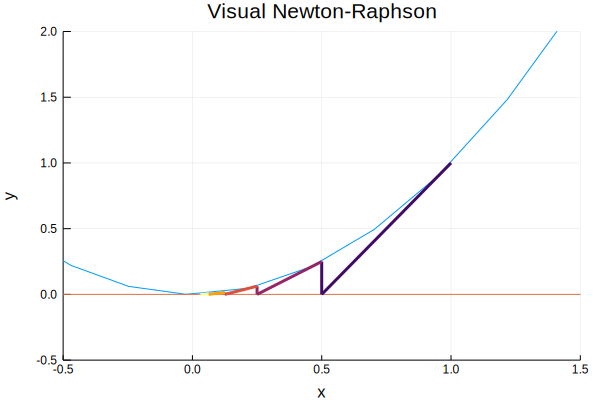

In [74]:
plot(x2,
    xlims=(-.5,1.5),ylims=(-.5,2),legend=false)
hline!([0])

for ii in 1:5
    plot!(x_NR_x2[(0:1).+ii],
        x2(x_NR_x2[ii]).+dx2(x_NR_x2[ii]).*(x_NR_x2[(0:1).+ii]
            .-x_NR_x2[ii])
        ,linewidth=3,color=cgrad(:inferno)[ii/5])
    plot!([x_NR_x2[1+ii],x_NR_x2[1+ii]],[0,x2(x_NR_x2[1+ii])]
        ,linewidth=3,color=cgrad(:inferno)[ii/5])
end
plot!(title="Visual Newton-Raphson",
    xlabel="x",ylabel="y")


Yeah... a bit slower.  But at least it will work, unlike the Midpoint algorithm.

And if we run it on $1/x$, instead of identifying the divergence as a zero, this method runs off to infinity, which technically is a zero.  By using this method and looking at how it behaves over the iterations, or by looking at a graph, we can determine that $\pm \infty$ are zeros of this next function.

In [23]:
x_NR_recip=Zero_Iterator(recip,Newtons,[2.0],[drecip],10)[1,:]

10-element Array{Float64,1}:
    2.0
    4.0
    8.0
   16.0
   32.0
   64.0
  128.0
  256.0
  512.0
 1024.0

### Cycles

Remember how I said you should generally know how your functions behaves before applying the algorithm?  In this next situation, the algorithm can get stuck in a loop just going back and forth between a couple of values, never actually approaching a zero.  

Even more problematically, these cycles tend to be stable, as the evaluation at the second starting point shows us.

More sophisticated methods than the one's I'm showing here and check to see if NR is returning less than linear convergence, and default to the Midpoint method in those circumstances.  This way, you can achieve the NR speedup, but keep the Midpoint method's robustness.

These are somehow related to [Newton Fractals](https://en.wikipedia.org/wiki/Newton_fractal) and some other mathematics I don't yet understand. Feel free to look them up if you feel so inclined.

In [17]:
# a loop where the iteration gets stuck between two points
x_NR_loop=Zero_Iterator(loop,Newtons,[1.0],[dloop],10)[1,:]

10-element Array{Float64,1}:
 1.0
 0.0
 1.0
 0.0
 1.0
 0.0
 1.0
 0.0
 1.0
 0.0

In [18]:
# perturb the starting point, and we still don't really go anywhere...
x_NR_loop2=Zero_Iterator(loop,Newtons,[1.05],[dloop],30)[1,:]

30-element Array{Float64,1}:
 1.05               
 0.2411089866156788 
 1.080175088368354  
 0.34702226735454855
 1.1694568340618148 
 0.5700574216796792 
 1.5895974204378045 
 1.0811390298381143 
 0.35006578755042594
 1.1726576780806912 
 0.576417062242596  
 1.6117570649270276 
 1.1002257790810774 
 ⋮                  
 1.1617591990955374 
 0.554410475712811  
 1.539289841744783  
 1.036448513259264  
 0.1854610569984695 
 1.0476743181195445 
 0.23196528385652648
 1.074220771179821  
 0.3277999978210737 
 1.1501586826356798 
 0.5298242289692244 
 1.470422869543373  

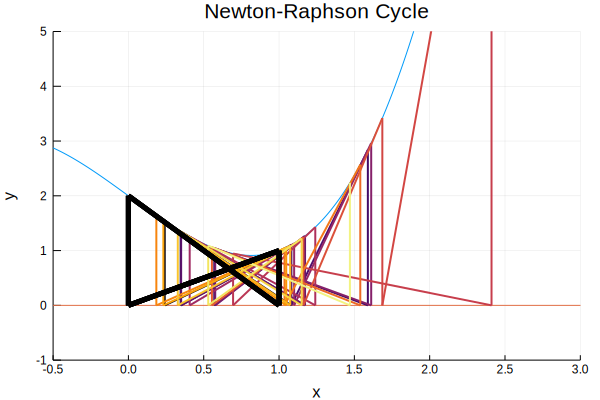

In [19]:
xloop=collect(-.5:.01:3)
plot(xloop,loop.(xloop),
    xlims=(-.5,3),ylims=(-1,5),legend=false)
hline!([0])

for ii in 1:29
    plot!(x_NR_loop2[(0:1).+ii],
        loop(x_NR_loop2[ii]).+dloop(x_NR_loop2[ii]).*(x_NR_loop2[(0:1).+ii]
            .-x_NR_loop2[ii])
        ,linewidth=2,color=cgrad(:inferno)[ii/30])
    plot!([x_NR_loop2[1+ii],x_NR_loop2[1+ii]],[0,loop(x_NR_loop2[1+ii])]
        ,linewidth=2,color=cgrad(:inferno)[ii/30])
end


for ii in 1:9
    plot!(x_NR_loop[(0:1).+ii],
        loop(x_NR_loop[ii]).+dloop(x_NR_loop[ii]).*(x_NR_loop[(0:1).+ii]
            .-x_NR_loop[ii])
        ,linewidth=5,color=:black)
    plot!([x_NR_loop[1+ii],x_NR_loop[1+ii]],[0,loop(x_NR_loop[1+ii])]
        ,linewidth=5,color=:black)
end

plot!(title="Newton-Raphson Cycle",
    xlabel="x",ylabel="y")

Here we can see in <b>black</b> the stationary cycle.  Colored by iteration, we can see the perturbed attempt.While is does move over a little to the right once, the path moves right back over to it's attractive stationary region.  No amount of iterations will get us any closer to a zero.

## Runaway Iteration

We can all agree that $\sqrt[3]{0}=0$, right?

At least all of us except for the Newton-Raphson method.  

The situation where the <i>derivative is undefined at the root</i> is another time when the algorithm fails and steps just run around willy-nilly giving us meaningless nothing.

In [48]:
x_NR_cubert=Zero_Iterator(cubert,Newtons,[1.0],[dcubert],10)[1,:]

10-element Array{Float64,1}:
    1.0
   -2.0
    4.0
   -8.0
   16.0
  -32.0
   64.0
 -128.0
  256.0
 -512.0

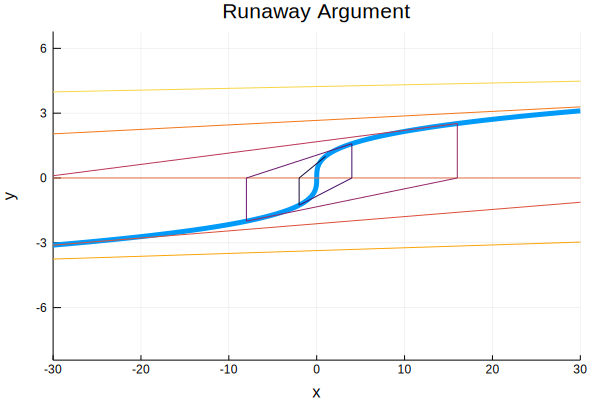

In [67]:
x_cubert=collect(-30:0.01:30)

plot(x_cubert,cubert.(x_cubert),linewidth=5
    ,xlims=(-30,30),legend=false)
hline!([0])

for ii in 1:9
    plot!(x_NR_cubert[(0:1).+ii],
        cubert(x_NR_cubert[ii]).+dcubert(x_NR_cubert[ii]).*(x_NR_cubert[(0:1).+ii]
            .-x_NR_cubert[ii])
        ,linewidth=1,color=cgrad(:inferno)[ii/10])
    plot!([x_NR_cubert[1+ii],x_NR_cubert[1+ii]],[0,cubert(x_NR_cubert[1+ii])]
        ,linewidth=1,color=cgrad(:inferno)[ii/10])
end
plot!(title="Runaway Argument",
    xlabel="x",ylabel="y")

## Secant Method

This method fixes the Newton-Raphson Method's requirement for a derivative by using two points to calculate an approximate derivative. 

If you try to get an accurate derivative by evaluating the function at points close to each other, we are wasting a function evaluation. We might get information on the derivative, but we don't get any new information on the function, even though we are re-evaluating the function.  

We can fix this by spacing apart the points we use to calculate the secant.  After the first two points we use to initialize, the algorithm uses the last two iteration values.  This way we calculate as little new things as possible.

In [25]:
# x[1:2] are last two points
# x[2] more recent and x[1] older
# x[3:4] are f values of last two points
function Secant(f::Function,x::Array,params::Array)
    xnew= x[2] - x[4]*(x[2]-x[1])/(x[4]-x[3])
    return [x[2], xnew, x[4], f(xnew)]
end

Secant (generic function with 1 method)

In [26]:
x_S_f=Zero_Iterator(f,Secant,[2.,1.5,f(2.0),f(1.5)],["null"],10)
dx_S_f=x_S_f[2,:]-x_S_f[1,:]

10-element Array{Float64,1}:
  -0.5                   
  -0.4363849163049389    
   0.007916427022864214  
   0.0003336224830581269 
  -4.1258247596154263e-7 
   2.0476065287766687e-11
   0.0                   
 NaN                     
 NaN                     
 NaN                     

In [35]:
x_S_x2=Zero_Iterator(x2,Secant,[-1,.8,x2(-1.),x2(.8)],["null"],10)
dx_S_x2=x_S_x2[2,:].-x_S_x2[2,end]

println("ii \t Guess \t\t\t dx")
for ii in 1:length(x_S_x2[1,:])
    println(ii,"\t",x_S_x2[2,ii],"\t",dx_S_x2[ii])
end

ii 	 Guess 			 dx
1	0.8	0.7712230215827338
2	4.000000000000002	3.9712230215827358
3	0.6666666666666665	0.6378896882494003
4	0.5714285714285714	0.5426515930113052
5	0.30769230769230765	0.2789153292750415
6	0.19999999999999998	0.17122302158273378
7	0.1212121212121212	0.09243514279485501
8	0.07547169811320753	0.04669471969594134
9	0.046511627906976744	0.017734649489710555
10	0.02877697841726619	0.0


Working ... kinda ?

But when you think geometrically about what this situation is, I'm rather amazed that this set of initial points $(-1, .8)$ works at all.  Look at the limiting situation of $(-a,a)$ to get an idea of when the method can fail completely.

In [36]:
Zero_Iterator(x2,Secant,[-1.,1.,x2(-1.),x2(1.)],["null"],10)

4×10 Array{Float64,2}:
 -1.0     1.0  -Inf  NaN  NaN  NaN  NaN  NaN  NaN  NaN
  1.0  -Inf     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
  1.0     1.0   Inf  NaN  NaN  NaN  NaN  NaN  NaN  NaN
  1.0   Inf     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

## Regula- Falsi Method

The Regula- Falsi Method combines Midpoint and Secant Method.  It uses the potential speedup due to derivatives, but avoids some pitfalls by staying bracketed.

In [75]:
function RegulaFalsi(f::Function, x::Array{Float64},params)
    if f(x[1])*f(x[2])>0
        println("Endpoints must bracket a zero.  Please pick better endpoints.")
        error()
    end
    
    c= x[2] - x[4]*(x[2]-x[1])/(x[4]-x[3])
    
    if f(x[1])*f(c)<0
        return [ x[1],c,x[3],f(c) , c]
        
    elseif f(c)*f(x[2])<0
        return [c, x[2], f(c) , x[4] , c]
        
    elseif f(c) ==0 
        print("midpoint is zero")
        return [x,x,f(c),f(c) , c]
    else   
        println("Mid point doesn't bracket a zero... somethign weird...")
        print(c,"\t",f(c))
    end
end

RegulaFalsi (generic function with 1 method)

In [76]:
x_RF_f=Zero_Iterator(f,RegulaFalsi,[-1.,2.,f(-1.),f(2.),-1.],["null"],10)
dx_RF_f=x_RF_f[5,:].-x_RF_f[end]

10-element Array{Float64,1}:
 -2.071864720637038    
 -0.6537077548263073   
 -0.06880892316102294  
 -0.00260388104164222  
 -7.907110959903818e-5 
 -2.3785634690742796e-6
 -7.152788894515538e-8 
 -2.1491297630404915e-9
 -6.274269992445625e-11
  0.0                  

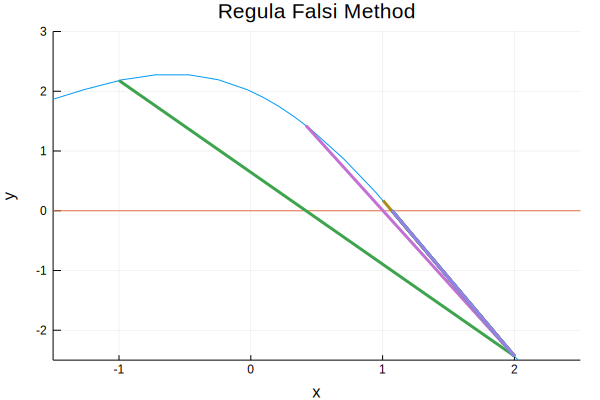

In [77]:
plot(f
    ,xlims=(-1.5,2.5),ylims=(-2.5,3),legend=false)
hline!([0])
plot!(x_RF_f[1:2,:],x_RF_f[3:4,:],linewidth=3)

plot!(xlabel="x",ylabel="y",title="Regula Falsi Method")

So when might we want to use this trait of staying bracketed?

Let's apply this algorithm to the cube root function $\sqrt[3]{x}$ that the Newton-Raphson method failed so miserably on:

In [78]:
x_RF_cubert=Zero_Iterator(cubert,RegulaFalsi,[-1.,2.,cubert(-1.),cubert(2.),-1.],["null"],10)

5×10 Array{Float64,2}:
 -1.0      -1.0       -0.214174  -0.214174   …  -0.00114702  -0.00114702
  2.0       0.32748    0.32748    0.0375178      0.00141547   8.93351e-5
 -1.0      -1.0       -0.598304  -0.598304      -0.104678    -0.104678  
  1.25992   0.689279   0.689279   0.33477        0.112279     0.0447034 
 -1.0       0.32748   -0.214174   0.0375178     -0.00114702   8.93351e-5

And that Regula Falsi actually converges to $0$ instead of running off to infinity! Yay!

## Comparison of Results

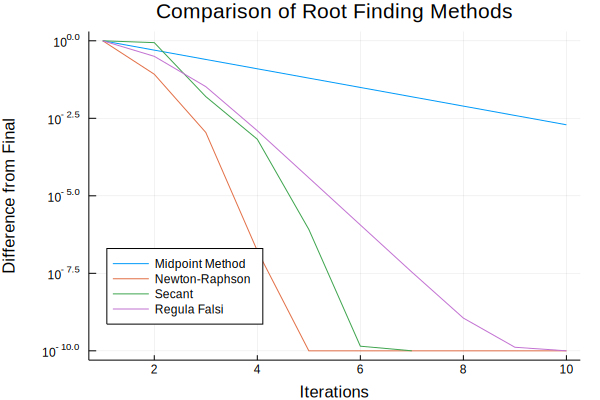

In [27]:
plot(abs.(dx_M_f/dx_M_f[1]).+1e-10,label="Midpoint Method")
plot!(abs.(dx_NR_f/dx_NR_f[1]).+1e-10,label="Newton-Raphson")
plot!(abs.(dx_S_f/dx_S_f[1]).+1e-10,label="Secant")
plot!(abs.(dx_RF_f/dx_RF_f[1]).+1e-10,label="Regula Falsi")

plot!(yscale=:log,legend=:bottomleft,xlabel="Iterations",ylabel="Difference from Final",
    title="Comparison of Root Finding Methods")

In comparing the convergence rates on a non-complicated transcendental function, we see that NR converges the fastest, followed by Secant, then Regula-Falsi, and finally the Midpoint method.  

But the NR and Secant Methods have about the same slope once the algorithm is "burned in", or less affected by our crappy initial choices.  

Remember, that I could only really even make this plot for the function 'f'.  The other functions broke down on one or more methods (though I did choose the functions because they would break down).

$x^2$ can't be bracketed and therefore does not apply to either the Midpoint method or Regula Falsi.  The loop function $x^3-2x+2$ would never converge.  $1/x$ could have a divergence misinterpreted as a zero. The Cuberoot $\sqrt[3]{x}$ runs off to infinity on the NR method.

From this, remember:

<b>One Method Does Not Rule Them All</b>

## What Next?

Awesome bonus to 1D root finding: Fractals!  
![](../images/Roots/zeros_fractal.png)
If we color the complex plane by which zero of $x^3-1$ each point will converge to under the Newton-Raphson method, we generate this awesome picture.

After 1D Roots, I hope to look at 2+D Roots, which are supprisingly much more complicated.  But most problems are not in one dimension, so it's about time I learned some of those methods.

I got onto root finding through boundary value problems, so hopefully I'll have something about that soon too.